# A coding introduction to the Markov Decision Process

<br><br>

In this notebook we will practice the concepts learned about control tasks and Markov decision processes. In particular, we will get familiar with a software library called OpenAI Gym that will provide us with a simple interface to these tasks.
<br><br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 2 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>


<br><br>


In [ ]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


## Quick view of the Gym library:
<br/>
<br/>

Gym is a library for reinforcement learning research. It provides us with a simple interface to a large number of tasks, including

- Classic control tasks (CartPole, Pendulum, MountainCar, etc)
- Classic video games (Space Invaders, Breakout, Pong, etc)
- Continuous control tasks
- Robotic arm manipulation

In this section we are going to get familiar with the five methods that we'll use while solving a control
task.


<br/>
<br/>


![title](https://github.com/escape-velocity-labs/beginner_master_rl/blob/main/img/mdp_diagram.svg?raw=1)

###### Source: https://upload.wikimedia.org/wikipedia/commons/1/1b/Reinforcement_learning_diagram.svg

##### Making the environment: Maze()

To create an environment, just pass a string with its name to the gym.make method. If the environment exists, the method returns an instance of the gym.Env class, which represents the environment of the task we are going to solve.

In [ ]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
env = Maze()

###### env.reset()

This method places the environment in its initial state to  and returns it so that the agent can observe it.


In [ ]:
initial_state = env.reset()
print(f"The new episode will start in state: {initial_state}")

##### env.render()

This method generates an image that represents the current state of the environment, in the form of a np.ndarray.

In [ ]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {initial_state}")
plt.imshow(frame)

##### env.step()

This method applies the action selected by the agent in the environment, to modify it. In response, the environment returns a tuple of four objects:

- The next state
- The reward obtained
- (bool) if the task has been completed
- any other relevant information in a python dictionary

In [ ]:
action = 2
next_state, reward, done, info = env.step(action)
print(f"After moving down 1 row, the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

###### Render the new state

In [ ]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {next_state}")
plt.imshow(frame)

##### env.close()

It completes the task and closes the environment, releasing the associated resources.

In [ ]:
env.close()

## Maze environment: Find the exit.


In this section we are going to familiarize ourselves with the environment that we'll use in the lessons 2 (dynamic programming), 3 (Monte Carlo methods) and 4 (temporal difference methods). This environment is perfect for learning the basics of Reinforcement Learning because:

- It has few states (25)
- Transitions between states are deterministic ($p(s', r| s, a) = 1$)
- All rewards are the same (-1) until the episode concludes. Thus facilitating the study of the value and action-value functions

Through this environment, we are going to review the concepts seen in lesson 1 (The Markov decision process):

- States and state space
- Actions and action space
- Trajectories and episodes
- Rewards and returns
- Policy


The environment is a maze of 5x5 cells, in which the goal of the agent is to find the exit, located in the lower right corner, in the cell (4,4). In the image, the exit is colored in light green.

To reach the exit, the agent can take four different actions: move up, move down, move left and move right.

###### Create the environment.

In [ ]:
env = Maze()

##### States and state space

The states consist of a tuple of two integers, both in the range [0, 4], representing the row and column in which the agent is currently located:
<br>
<br>

\begin{equation}
    s = (row, column) \;\\
    row, column \in \{0,1,2,3, 4\}
\end{equation}
<br>
<br>
The state space (set of all possible states in the task) has 25 elements (all possible combinations of rows and columns):


\begin{equation}
    Rows \times Columns \;\\
    S = \{(0, 0), (0, 1), (1, 0), ...\}
\end{equation}

Information about the state space is stored in the env.observation_space property. In this environment, it is of MultiDiscrete([5 5]) type, which means that it consists of two elements (rows and columns), each with 5 different values.

In [ ]:
print(f"For example, the initial state is: {env.reset()}")
print(f"The space state is of type: {env.observation_space}")

##### Actions and action space

In this environment, there are four different actions and they are represented by integers:

\begin{equation}
a \in \{0, 1, 2, 3\}
\end{equation}

- 0 -> move up
- 1 -> move right
- 2 -> move down
- 3 -> move left

To execute an action, simply pass it as an argument to the env.step method. Information about the action space is stored in the env.action_space property which is of Discrete(4) class. This means that in this case it only consists of an element in the range [0,4), unlike the state space seen above.


In [ ]:
print(f"An example of a valid action is: {env.action_space.sample()}")
print(f"The action state is of type: {env.action_space}")

##### Trajectories and episodes

A trajectory is the sequence generated by moving from one state to another (both arbitrary)

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_N, S_N,
\end{equation}

Let's generate a trajectory of 3 moves in code:

In [ ]:
env = Maze()
state = env.reset()
trajectory = []
for _ in range(3):
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    trajectory.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f"Congrats! You just generated your first trajectory:\n{trajectory}")

An episode is a trajectory that goes from the initial state of the process to the final one:

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_T, S_T,
\end{equation}
where T is the terminal state.

Let's generate a whole episode in code:

In [ ]:
env = Maze()
state = env.reset()
episode = []
done = False
while not done:
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    episode.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f"Congrats! You just generated your first episode:\n{episode}")

##### Rewards and returns

A reward is numerical feedback that the environment generates when the agent takes an action *a* in a state *s*:

\begin{equation}
    r = r(s, a)
\end{equation}

Let's generate a reward from the environment:

In [ ]:
env = Maze()
state = env.reset()
action = env.action_space.sample()
_, reward, _, _ = env.step(action)
print(f"We achieved a reward of {reward} by taking action {action} in state {state}")

The return associated with a moment in time *t* is the sum (discounted) of rewards that the agent obtains from that moment. We are going to calculate $G_0$, that is, the return to the beginning of the episode:

\begin{equation}
    G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + ... + \gamma^{T-1} R_T
\end{equation}



Let's assume that the discount factor $\gamma = 0.99$:


In [ ]:
env = Maze()
state = env.reset()
done = False
gamma = 0.99
G_0 = 0
t = 0
while not done:
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    G_0 += gamma ** t * reward
    t += 1
env.close()

print(
    f"""It took us {t} moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to {G_0}""")

##### Policy

A policy is a function $\pi(a|s) \in [0, 1]$ that gives the probability of an action given the current state. The function takes the state and action as inputs and returns a float in [0,1].

Since in practice we will need to compute the probabilities of all actions, we will represent the policy as a function that takes the state as an argument and returns the probabilities associated with each of the actions. Thus, if the probabilities are:

[0.5, 0.3, 0.1]

we will understand that the action with index 0 has a 50% probability of being chosen, the one with index 1 has 30% and the one with index 2 has 10%.

Let's code a policy function that chooses actions randomly:

In [17]:
def random_policy(state):
    return np.array([0.25] * 4)

## Playing an episode with our random policy

###### Create and reset the environment

In [21]:
env = Maze()
state = env.reset()

Compute $p(a|s) \ \forall a \in \{0, 1, 2, 3\}$

In [22]:
action_probabilities = random_policy(state)

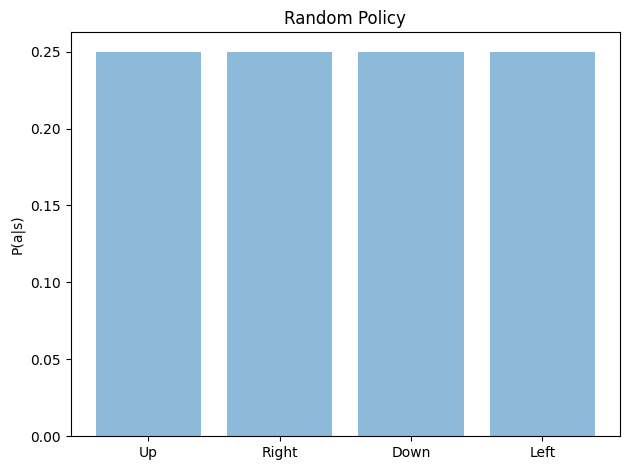

In [23]:
objects = ('Up', 'Right', 'Down', 'Left')
y_pos = np.arange(len(objects))

plt.bar(y_pos, action_probabilities, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('P(a|s)')
plt.title('Random Policy')
plt.tight_layout()

plt.show()

##### Use the policy to play an episode (This cell has been updated, read below)


Dear student, to keep the course content up to date, the code for displaying our policy facing the environment has been updated.
This function works the same way as described in the video, the only difference
is that now we save a screenshot of every state in the `frames` variable and then, we use the `display_video` function to turn those images into a video.

<br>

In any case, this is convenience code that is completely unrelated to Reinforcement Learning, so in the following notebooks, I'll just make it available to you in the first code cell (which you can just run and ignore, like you did this time). That way, you'll be able to focus on the important part.

Cheers!





In [24]:
def test_agent(environment, policy):
    frames = []
    state = env.reset()
    done = False
    frames.append(env.render(mode="rgb_array"))

    while not done:
        action_probs = policy(state)
        action = np.random.choice(range(4), 1, p=action_probs)
        next_state, reward, done, extra_info = env.step(action)
        img = env.render(mode="rgb_array")
        frames.append(img)
        state = next_state

    return display_video(frames)


test_agent(env, random_policy)